In [1]:
%pylab inline
import pandas as pd
import scipy as sp
from scipy import signal

import xarray as xr

import datetime
from collections import OrderedDict
DT = datetime.datetime

Populating the interactive namespace from numpy and matplotlib


In [24]:
class PeakSearch(object):
    def __init__(self):
        fname = "north_america_rbn_filtered.csv.bz2"

        df_0 = pd.read_csv(fname,parse_dates=['datetime'])

        keys=[]
        keys.append('datetime')
        keys.append('frequency')
        keys.append('band')
        keys.append('R_gc')
        keys.append('azm')
        keys.append('call_0')
        keys.append('lat_0')
        keys.append('lon_0')
        keys.append('call_1')
        keys.append('lat_1')
        keys.append('lon_1')
        keys.append('lat_mid')
        keys.append('lon_mid')
        keys.append('srpt_0')
        #keys.append('obs_mid_300km')
        df=df_0[keys].copy()

        def ut_hr(dt):
            result = dt.hour + dt.minute/60. + dt.second/3600.
            return result
        
        df.loc[:,'ut_hr'] = df.datetime.map(ut_hr)
        
        self.df = df
        
        self.fit_list = []

    def set_calls(self,call_0,call_1,band):
        self.call_0 = call_0
        self.call_1 = call_1
        self.band   = band
        df = self.df
        
        dft=df.copy()
        tf=dft['call_0']==call_0
        dft=dft[tf]

        tf=dft['call_1']==call_1
        dft=dft[tf]

        tf=dft['band']==band
        dft=dft[tf]
        
        self.dft = dft
        self.plot_snr(marker=None)
        
    def plot_snr(self,dt_0=None,dt_1=None,marker='o'):
        call_0 = self.call_0
        call_1 = self.call_1
        band   = self.band
        
        dft    = self.dft

        xx     = dft['datetime']
        yy     = dft['srpt_0']
        
        plt.figure(figsize=(10,8))
        plt.plot(xx,yy,marker=marker)
        plt.xlim(dt_0,dt_1)
        plt.xlabel('Time(UT)')
        plt.ylabel('SNR')
        
        title = '{!s} from {!s} at {!s} MHz'.format(call_0,call_1,band)
        plt.title(title)
        plt.grid()
        plt.show()
    def lombscargle(self,Tlim=(1,60),winLen_min=120,winStep_min=30):
        # Pick Frequencies
        T     = np.arange(*Tlim)*60.
        omega = 2*np.pi*(1./T)

        dft = self.df[['ut_hr','srpt_0']]

        win_len  = datetime.timedelta(minutes=winLen_min)
        win_step = datetime.timedelta(minutes=winStep_min)

        t0 = dft['ut_hr'].min()
        t1 = dft['ut_hr'].max()

        windows   = []
        win_times = []
        while t0 < (t1-win_len.total_seconds()/3600.):
            tf  = np.logical_and(dft['ut_hr'] >= t0,dft['ut_hr'] < t0+(win_len.total_seconds()/3600.))
            tmp = dft[tf].copy()
            windows.append(tmp)
            win_times.append(t0)
            t0 += win_step.total_seconds()/3600.

        lsps      = []
        for window in windows:
            x = window['ut_hr']*3600. #UT Time in Seconds
            y = window['srpt_0']

            lsp = sp.signal.lombscargle(x,y,omega)
            lsps.append(lsp)

        coords = []
        coords.append(('UT Time', win_times))
        coords.append(('Period [min]', T/60.))

        lsp_da = xr.DataArray(np.array(lsps),coords=coords)
        
        self.lsp_da = lsp_da
        self.plot_lombscargle()
    
    def plot_lombscargle(self,figsize=(10,6)):
        fig = plt.figure(figsize=figsize)
        ax  = fig.add_subplot(111)
        self.lsp_da.plot.pcolormesh('UT Time','Period [min]',ax=ax)
        fig.show()
    
    def lombscargle_line(self,ut0=None,ut1=None,Tlim=(1,60)):
        # Pick Frequencies
        T     = np.arange(*Tlim)*60.
        omega = 2*np.pi*(1./T)
        
        dft = self.df[['ut_hr','srpt_0']]
        
        if ut0 is None: ut0 = dft['ut_hr'].min()
        if ut1 is None: ut1 = dft['ut_hr'].max()
        
        tf  = np.logical_and(dft['ut_hr'] >= ut0,dft['ut_hr'] < ut1)
        dft = dft[tf].copy()
        
        x = dft['ut_hr']*3600
        y = dft['srpt_0']
    
        lsp = sp.signal.lombscargle(x,y,omega)

        fig = plt.figure()
        ax  = fig.add_subplot(111)
        ax.plot(T/60.,lsp)
        ax.set_xlabel('Period [min]')
        ax.set_ylabel('LombScargle')
        fig.show()
                
ps  = PeakSearch()

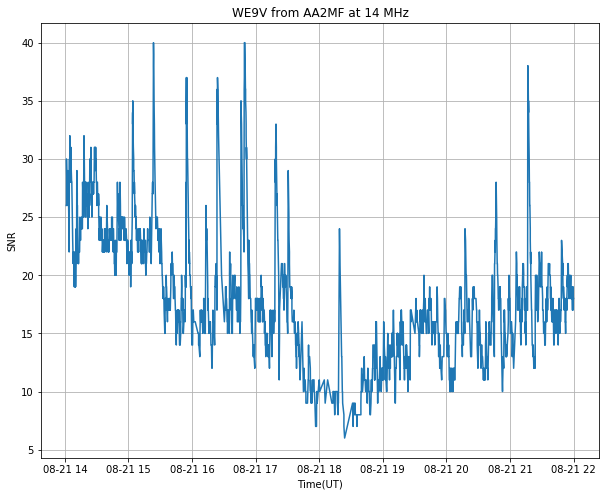

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


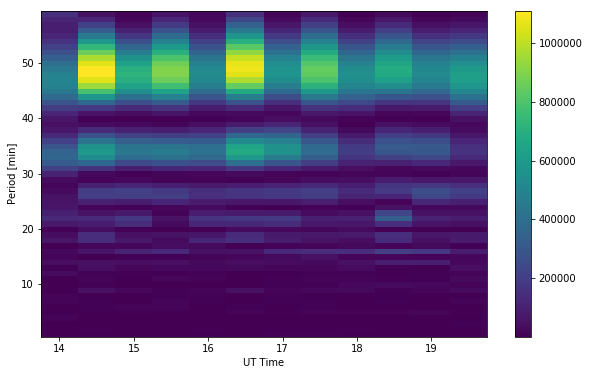

In [19]:
ps.set_calls(call_0='WE9V',call_1='AA2MF',band=14)
#ps.plot_snr(DT(2017,8,21,18),DT(2017,8,21,20)
ps.lombscargle()

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


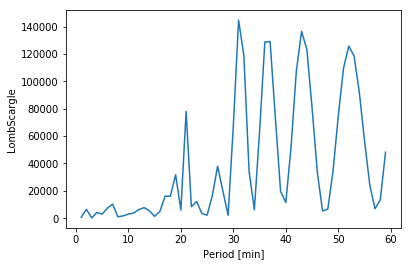

In [25]:
ps.lombscargle_line(14,18)